A household survey was conducted in Rwanda in 2014-2015. There were hunderds of questions asked. In this notebook, using pymc3, we will analyze the wealth index reported. Specifically, we will do unsupervised clustering using Pymc3's mixture models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1154]:
fields = ['v191'] # Wealth index
df = pd.read_stata('RWIR70FL.DTA', columns=fields)

In [1155]:
# Divide by 1000 to reduce proportional size of values of wealth index. Should make modeling easier/faster to run. 
df.v191 = df.v191/1000

In [1141]:
mixture = df.copy()
mixture = mixture[::10]  # Due to computational limitations, use 1/10 of the data
mixture.v191 = np.array(mixture.v191)
data = mixture.v191
np.savetxt("wealth.csv", data, delimiter=",")

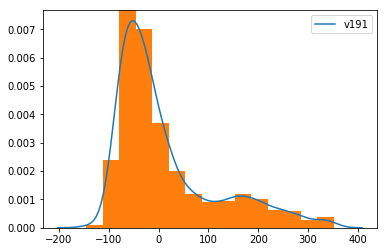

In [1142]:
sns.kdeplot(data)
plt.hist(data, normed=True, bins=15)
plt.savefig("KDEdata")
plt.show()

In [1156]:
data.head()

0     -40.240
10    -34.385
20    117.466
30     89.384
40    -19.331
Name: v191, dtype: float64

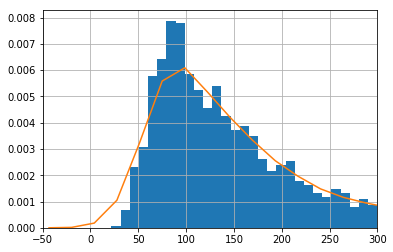

In [1211]:
# Simulation of pm.InverseGamma('hyp_sd1', alpha=3, beta=360) in estimating hyperparameters for std
plt.hist(stats.invgamma.rvs(a=3, scale=360, size=data.size, random_state=13), bins=300,normed=True)
sns.kdeplot(stats.invgamma.rvs(a=3, scale=360, size=data.size, random_state=13))
plt.xlim(-50,300)
plt.grid()
plt.savefig("hyperpara_InvGamma")
plt.show()

In [1144]:
with pm.Model() as model:

        # Using pm.Mixture with StudentT distribution
    #hyper_mean = pm.Normal('hyper_mean', mu=-70, sd=100)
    #hyper_mean1 = pm.Normal('hyper_mean1', mu=170, sd=100)
    #hyper_sigma = pm.HalfNormal('hyper_sigma', sd=45)
    #hyper_sigma1 = pm.HalfNormal('hyper_sigma1', sd=90)
    #nu = pm.Exponential('nu', 1./15, testval = 4)
    #nu1 = pm.Exponential('nu1', 1./15, testval = 4)
    #component = pm.StudentT.dist(mu=hyper_mean, sd=hyper_sigma, nu=nu)
    #component1 = pm.StudentT.dist(mu=hyper_mean1, sd=hyper_sigma1, nu=nu)  
    #like = pm.Mixture('like', w=w, comp_dists=[component, component1], observed=data)
    
        # Using pm.NormalMixture (Normal distribution is the default)
    #mu = pm.Uniform('mu', -100, 250, shape=2, testval=[-50, 100])
    #sd = pm.Uniform('sd', 0, 150, shape=2, testval=[30, 90])
    #like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=data)

        # Using pm.Mixture with Guassian distribution 
    hyp_mean = pm.Normal('hyp_mean', mu=-50, sd=50)
    hyp_mean1 = pm.Normal('hyp_mean1', mu=120, sd=100)
    #the chief use of the inverse gamma distribution is in Bayesian statistics, where the distribution 
    #arises as the marginal posterior distribution for the unknown variance of a normal distribution
    hyp_sd = pm.InverseGamma('hyp_sd', alpha=2, beta=85)  
    hyp_sd1 = pm.InverseGamma('hyp_sd1', alpha=3, beta=360)
    component = pm.Normal.dist(mu=hyp_mean, sd=hyp_sd)
    component1 = pm.Normal.dist(mu=hyp_mean1, sd=hyp_sd1)

    w = pm.Dirichlet('w', a=np.array([1, 1]))

    like = pm.Mixture('like', w=w, comp_dists=[component, component1], observed=data)

In [1145]:
with model:
    trace = pm.sample(7000, tune=4000, njobs=1)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w_stickbreaking__, hyp_sd1_log__, hyp_sd_log__, hyp_mean1, hyp_mean]
100%|███████████████████████████████████████████████████████████████████████████| 11000/11000 [01:02<00:00, 174.61it/s]


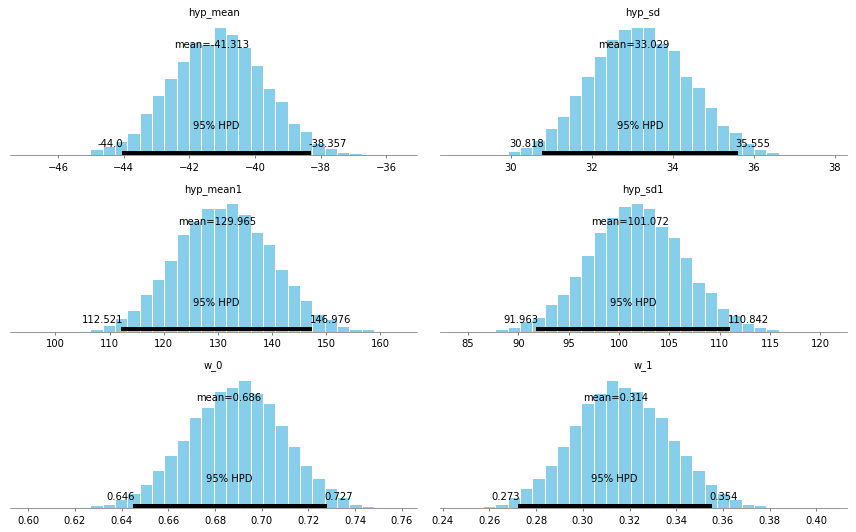

In [1152]:
pm.plot_posterior(trace, varnames=['hyp_mean', 'hyp_sd', 'hyp_mean1','hyp_sd1', 'w'], color='#87ceeb')
plt.savefig("plot_post")
plt.show()

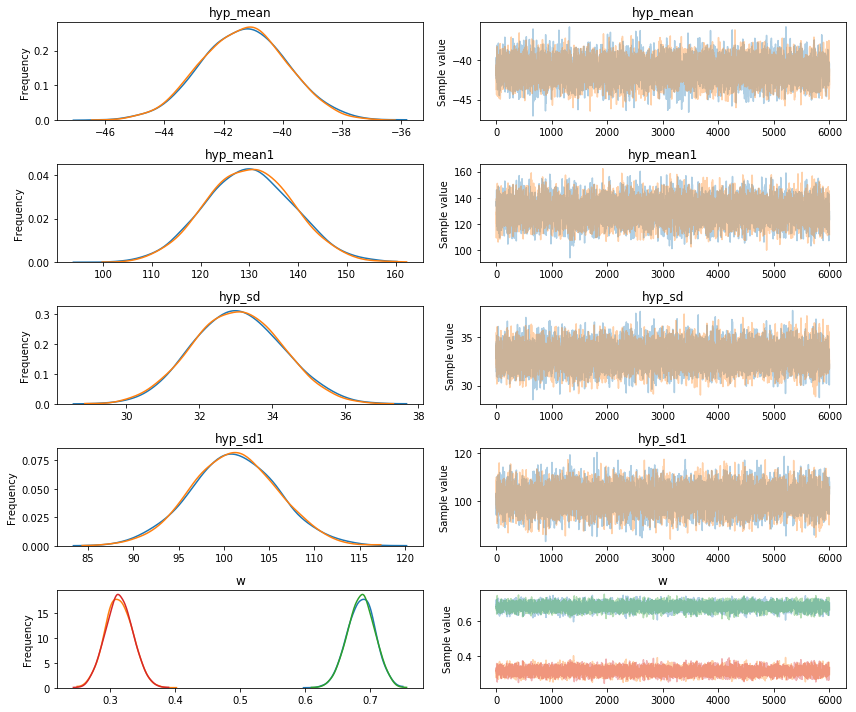

In [1153]:
pm.traceplot(trace)
plt.savefig("traceplot")
plt.show()

In [1151]:
pm.summary(trace) #Guassian dist, pm.Mixture 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
hyp_mean,-41.313262,1.452054,0.018710,-43.999761,-38.356594,6462.006901,1.000395
hyp_mean1,129.965409,8.861264,0.127272,112.521138,146.975899,5225.194843,0.999951
hyp_sd,33.029218,1.220782,0.015897,30.818071,35.555485,5851.736086,1.000075
hyp_sd1,101.071806,4.802580,0.063784,91.963301,110.841839,6790.188215,0.999918
w__0,0.685989,0.020830,0.000302,0.645674,0.726977,5010.101139,1.000016
w__1,0.314011,0.020830,0.000302,0.273023,0.354326,5010.101139,1.000016


In [289]:
pm.summary(trace) # StudentT. See how the sd of each value is larger than those using Normal distribution above.

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
hyper_mean,-48.537012,3.602072,0.055069,-55.542278,-41.444344,4942.798171,0.999986
hyper_mean1,104.351379,21.747071,0.323602,64.570638,149.200649,4589.635400,0.999950
hyper_sigma,28.792741,3.215292,0.048580,22.467385,34.907718,4739.034892,0.999966
hyper_sigma1,91.438628,9.713601,0.115695,73.010334,111.834670,6214.703505,0.999974
nu,30.181315,17.695728,0.168349,6.324516,65.349888,8844.258021,1.000000
nu1,14.810833,14.521896,0.167539,0.001834,43.391803,9983.688140,1.000584
w__0,0.702167,0.055035,0.000850,0.591749,0.804868,4652.503162,0.999937
w__1,0.297833,0.055035,0.000850,0.195132,0.408251,4652.503162,0.999937


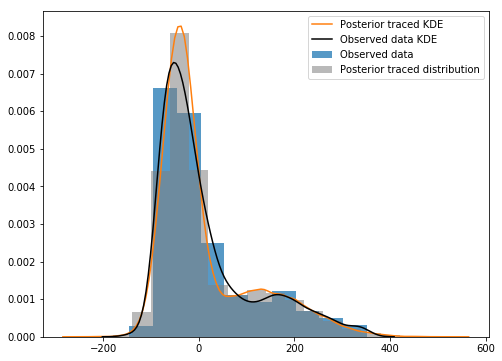

In [1146]:
# Guassian example
N = 100000 

W = np.array([trace['w'][:,0].mean(), trace['w'][:,1].mean()])

mu = np.array([trace['hyp_mean'].mean(),trace['hyp_mean1'].mean()])
sd = np.array([trace['hyp_sd'].mean(),trace['hyp_sd1'].mean()])

component = np.random.choice(mu.size, size=N, p=W)
x = stats.norm.rvs(loc=mu[component], scale=sd[component], size=N)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(data, bins=10, normed=True, lw=0, alpha=.75, label='Observed data')
ax.hist(x, bins=20, normed=True, lw=0, alpha=0.55, color='gray', label='Posterior traced distribution')
sns.kdeplot(x, label='Posterior traced KDE')
sns.kdeplot(data, label='Observed data KDE', color='black')
plt.legend()
plt.savefig("visualize")
plt.show()

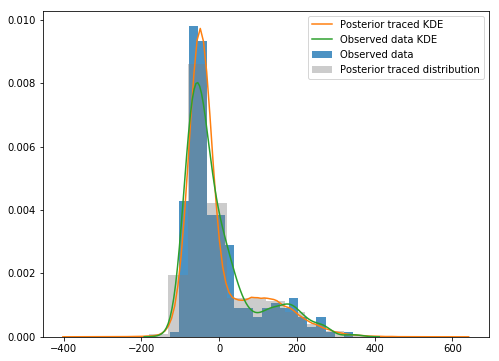

In [312]:
N = 100000 #StudentT example. See how the tails are wider than the visualization above.

W = np.array([trace['w'][:,0].mean(), trace['w'][:,1].mean()])

mu = np.array([trace['hyper_mean'].mean(),trace['hyper_mean1'].mean()])
sd = np.array([trace['hyper_sigma'].mean(),trace['hyper_sigma1'].mean()])
nu = np.array([trace['nu'].mean(),trace['nu1'].mean()])

component = np.random.choice(mu.size, size=N, p=W)
x = stats.t.rvs(df=nu[component], loc=mu[component], scale=sd[component], size=N)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(data, bins=20, normed=True, lw=0, alpha=.8, label='Observed data')
ax.hist(x, bins=20, normed=True, lw=0, alpha=0.4, color='gray', label='Posterior traced distribution')
sns.kdeplot(x, label='Posterior traced KDE')
sns.kdeplot(data, label='Observed data KDE')
plt.legend()
plt.show()

In [1147]:
with model:
    ppc_trace = pm.sample_ppc(trace, 7000)

100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:08<00:00, 820.68it/s]


**Lay posterior predictive samples on top of observed data to visualize alignment**

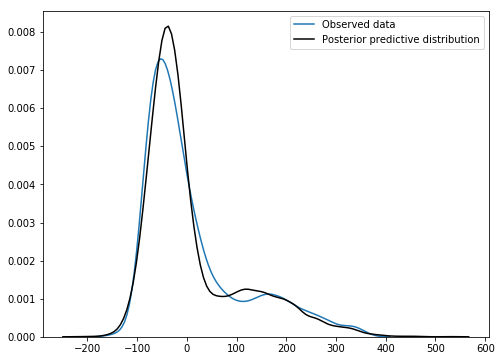

In [1148]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.hist(data, bins=20, normed=True,
#         histtype='step', lw=2,
#         label='Observed data');
# ax.hist(ppc_trace['like'], bins=30, normed=True,
#         histtype='step', lw=2,
#         label='Posterior predictive distribution');
sns.kdeplot(data, label='Observed data')
sns.kdeplot(ppc_trace['like'], color='black', label='Posterior predictive distribution')
ax.legend(loc=1);

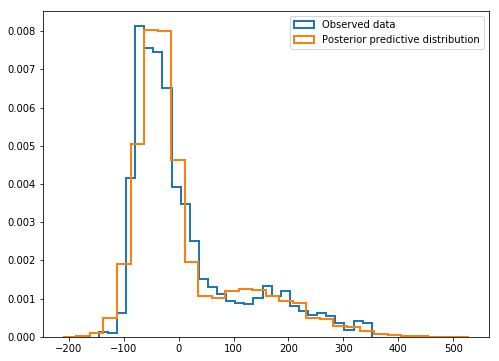

In [1208]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(data, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['like'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');
ax.legend(loc=1);

#  Predictive analysis to determine the cluster probability of each value

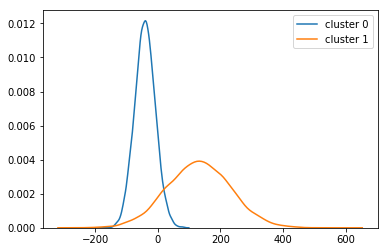

In [1207]:
# Recreate distributions from trace
np.random.seed(seed=13)
x0 = pm.Normal.dist(mu=trace['hyp_mean'], sd=trace['hyp_sd']).random(100000)
x1 = pm.Normal.dist(mu=trace['hyp_mean1'], sd=trace['hyp_sd1']).random(100000)

sns.kdeplot(x0, label='cluster 0')
sns.kdeplot(x1, label='cluster 1')
# plt.xlim(0,50) area where lines intersect
plt.legend()
plt.show()

In [1205]:
normal_pdf = stats.norm.pdf

prob_cluster_0 = trace['w'][:,0] # P(Lx=0)
prob_cluster_1 = trace['w'][:,1] # P(Lx=1)


x=30.8

v = normal_pdf(x, loc=trace['hyp_mean1'], scale=trace['hyp_sd1']) * (prob_cluster_1) > \
    normal_pdf(x, loc=trace['hyp_mean'], scale=trace['hyp_sd']) * (prob_cluster_0)
    
print("Probability of belonging to cluster one when x=30.8: "+str(v.mean()))

Probability of belonging to cluster one when x=30.8: 0.5034166666666666


Although the lines of the two clusters intersect at 20 and intuitively anything over 20 should belong to cluster 1, values under 30.8 still have higher probability of belonging to cluser 0. This is because cluster 0 has more data points and its std is much smaller; thus, we are more confident about values under its distribution.

**Let's go back to the dataframe and categorize any household under 30.9 as one cluster, and anyone equal or over 30.9 as the other cluster**

In [1187]:
df = df.loc[np.array(data.index)]

C:\Users\adam\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [1195]:
df['wealthy_or_not'] = 0
df.loc[df.v191>=30.8, 'wealthy_or_not'] = 1

In [1197]:
df.head(10)

,v191,wealthy_or_not
0,-40.240,0
10,-34.385,0
20,117.466,1
30,89.384,1
40,-19.331,0
50,-12.460,0
60,-88.432,0
70,-26.386,0
80,-72.962,0
90,-79.824,0
